In [1]:
import os
from google.cloud import bigquery
import pandas as pd 

In [2]:
#set environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= '/Users/jordanmaulino/Downloads/coastal-dynamo-309722-2032fe38e9cd.json'

In [3]:
client = bigquery.Client()

In [4]:
dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

dataset=client.get_dataset(dataset_ref)

In [5]:
tables = list(client.list_tables(dataset))

In [6]:
for table in tables: 
    print(table.table_id)

commits
contents
files
languages
licenses
sample_commits
sample_contents
sample_files
sample_repos


## Languages Data

In [7]:
table_ref = dataset_ref.table("languages")

table=client.get_table(table_ref)

In [8]:
client.list_rows(table, max_results=5).to_dataframe()

,repo_name,language
0,staskobzar/res_zonkey_mwi,"[{'name': 'C', 'bytes': 20886}]"
1,ovaskevich/png2c,"[{'name': 'C', 'bytes': 8589}]"
2,nu774/libsoxconvolver,"[{'name': 'C', 'bytes': 136306}]"
3,E-Neo/scel2pyim,"[{'name': 'C', 'bytes': 5106}]"
4,acranbury/ti3combatanalyzer,"[{'name': 'C', 'bytes': 1213}]"


In [9]:
table.schema

[SchemaField('repo_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('language', 'RECORD', 'REPEATED', None, (SchemaField('name', 'STRING', 'NULLABLE', None, (), None), SchemaField('bytes', 'INTEGER', 'NULLABLE', None, (), None)), None)]

Now, let's find the most popular programming languages on Github.

In [10]:
#query to find the most popular languages
popular_languages_query = """
                    SELECT language.name as language_name, COUNT(*) AS num_repos
                    FROM `bigquery-public-data.github_repos.languages`,
                        UNNEST(language) AS language
                    GROUP BY language_name
                    ORDER BY num_repos DESC
                    """

query_job = client.query(popular_languages_query)

pop_lang = query_job.to_dataframe()

pop_lang.head()

,language_name,num_repos
0,JavaScript,1102723
1,CSS,816578
2,HTML,781474
3,Shell,639349
4,Python,549818


In [11]:
pop_lang.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   language_name  417 non-null    object
 1   num_repos      417 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.6+ KB


Since there's over 400 programming languages listed, let's take a look at just the top 10

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Top 10 Most Popular Languages on Github (by # of Repositories)')

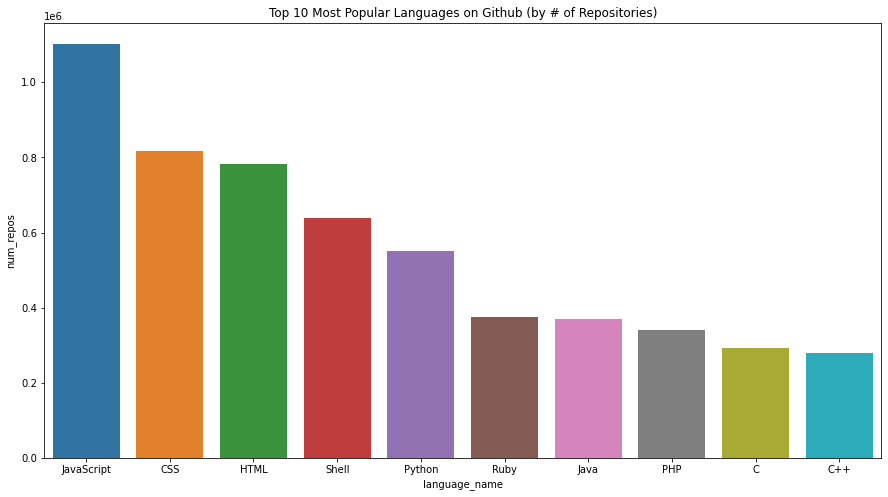

In [13]:
plt.figure(figsize=(15, 8))
sns.barplot(x="language_name", y="num_repos", data=pop_lang.loc[0:9])
plt.title("Top 10 Most Popular Languages on Github (by # of Repositories)")

Now let's write a query to see which repos contain the most languages

In [14]:
most_lang_query = """
                  SELECT repo_name, COUNT(DISTINCT l.name) AS num_languages
                  FROM `bigquery-public-data.github_repos.languages`,
                    UNNEST(language) as l
                  GROUP BY repo_name
                  ORDER BY num_languages DESC
                  """

query_job = client.query(most_lang_query)

most_lang = query_job.to_dataframe()

most_lang.head()

,repo_name,num_languages
0,polyrabbit/polyglot,216
1,mollstam/UnrealPy,159
2,nzavagli/UnrealPy,159
3,aswinpj/Pygments,154
4,objcio/pygments,153


Text(0.5, 1.0, 'Top 10 Repositories with the Most Programming Languages')

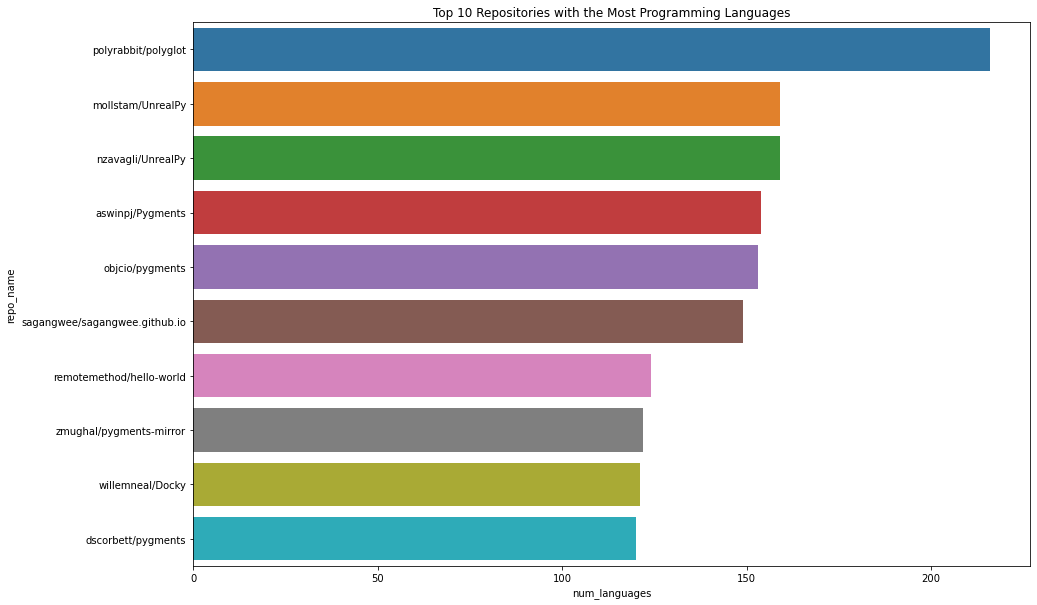

In [15]:
plt.figure(figsize=(15, 10))
sns.barplot(x="num_languages", y="repo_name", data=most_lang.loc[0:9])
plt.title("Top 10 Repositories with the Most Programming Languages")

Interesting...let's see which and how much of each language polyrabbit/polyglot uses

In [16]:
lang_query = """
             SELECT language.name, language.bytes
             FROM `bigquery-public-data.github_repos.languages`,
                UNNEST(language) AS language
             WHERE repo_name = 'polyrabbit/polyglot'
             ORDER BY language.bytes DESC
             """

query_job = client.query(lang_query)

polyglot_lang = query_job.to_dataframe()

polyglot_lang

,name,bytes
0,Lasso,834726
1,C,819142
2,Mercury,709952
3,Objective-C,495392
4,Game Maker Language,298131
...,...,...
211,XC,82
212,Arduino,81
213,Nimrod,43
214,AutoHotkey,23


## Sample Commits Data

In [17]:
table_ref = dataset_ref.table("sample_commits")

table=client.get_table(table_ref)

In [18]:
client.list_rows(table, max_results=5).to_dataframe()

,commit,tree,parent,author,committer,subject,message,trailer,difference,difference_truncated,repo_name,encoding
0,3eca86e75ec7a7d4b9a9c8091b11676f7bd2a39f,8e1b4380409a85a922ee0d3f622b5dd4d16bcfad,[104a0c02e8b1936c049e18a6d4e4ab040fb61213],"{'name': 'Mark Rutland', 'email': '1db9dd262be...","{'name': 'Catalin Marinas', 'email': '15ce75b2...",arm64: Remove fixmap include fragility,arm64: Remove fixmap include fragility\n\nThe ...,"[{'key': 'Signed-off-by', 'value': 'Mark Rutla...","[{'old_mode': 33188.0, 'new_mode': 33188.0, 'o...",None,torvalds/linux,None
1,7158627686f02319c50c8d9d78f75d4c8d126ff2,3b4d781bd966f07cad1b67b137f0ff8b89430e9a,[66aa8d6a145b6a66566b4fce219cc56c3d0e01c3],"{'name': 'Will Deacon', 'email': 'b913f13ef92a...","{'name': 'Catalin Marinas', 'email': '15ce75b2...",arm64: percpu: implement optimised pcpu access...,arm64: percpu: implement optimised pcpu access...,"[{'key': 'Signed-off-by', 'value': 'Will Deaco...","[{'old_mode': 33188.0, 'new_mode': 33188.0, 'o...",None,torvalds/linux,None
2,9732cafd9dc0206479be919baf0067239f0a63ca,c8878035ac9cb6dce592957f12dc1723a583989d,[f3c003f72dfb2497056bcbb864885837a1968ed5],"{'name': 'Jiang Liu', 'email': 'c745fa7b96fe79...","{'name': 'Catalin Marinas', 'email': '15ce75b2...","arm64, jump label: optimize jump label impleme...","arm64, jump label: optimize jump label impleme...","[{'key': 'Reviewed-by', 'value': 'Will Deacon ...","[{'old_mode': 33188.0, 'new_mode': 33188.0, 'o...",None,torvalds/linux,None
3,4702abd3f9728893ad5b0f4389e1902588510459,32926e7c55ef585d9b9c174a0e5f9ed13ed6bf7e,[ddf28352b80c86754a6424e3a61e8bdf9213b3c7],"{'name': 'Nicolas Pitre', 'email': '408789a210...","{'name': 'Arnd Bergmann', 'email': 'f2c659f019...",ARM: mach-nuc93x: delete,ARM: mach-nuc93x: delete\n\nThis architecture ...,"[{'key': 'Signed-off-by', 'value': 'Nicolas Pi...","[{'old_mode': 33188.0, 'new_mode': 33188.0, 'o...",None,torvalds/linux,None
4,57bd4b91a6cfc5bad4c5d829ef85293ea63643ea,2ffc2066eb7638e185663e9d849663403229d4e5,[f74c95c20bad8e183e41283475f68a3e7b247af4],"{'name': 'Ben Dooks', 'email': '1177f64998f284...","{'name': 'Ben Dooks', 'email': '1177f64998f284...",[ARM] S3C24XX: Movev udc headers to arch/arm/p...,[ARM] S3C24XX: Movev udc headers to arch/arm/p...,"[{'key': 'Signed-off-by', 'value': 'Ben Dooks ...","[{'old_mode': 33188.0, 'new_mode': 33188.0, 'o...",None,torvalds/linux,None


In [19]:
table.schema

[SchemaField('commit', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('tree', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('parent', 'STRING', 'REPEATED', None, (), None),
 SchemaField('author', 'RECORD', 'NULLABLE', None, (SchemaField('name', 'STRING', 'NULLABLE', None, (), None), SchemaField('email', 'STRING', 'NULLABLE', None, (), None), SchemaField('time_sec', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('tz_offset', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None)), None),
 SchemaField('committer', 'RECORD', 'NULLABLE', None, (SchemaField('name', 'STRING', 'NULLABLE', None, (), None), SchemaField('email', 'STRING', 'NULLABLE', None, (), None), SchemaField('time_sec', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('tz_offset', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None)), None),
 SchemaField('subject', 'STRING', 'NULLABLE', None, (), None),
 SchemaFie

Let's do another simple query to see who has the most commits. To save on run time, we'll use the sample_commits table, which is a small sample of GitHub commits. 

In [20]:
most_commits_query = """
                     SELECT committer.name AS committer_name, COUNT(*) AS num_commits
                     FROM `bigquery-public-data.github_repos.sample_commits`
                     GROUP BY committer_name
                     ORDER BY num_commits DESC
                     """


query_job = client.query(most_commits_query)

most_commits = query_job.to_dataframe()

most_commits.head()

,committer_name,num_commits
0,Linus Torvalds,65331
1,Greg Kroah-Hartman,57661
2,David S. Miller,54669
3,Mauro Carvalho Chehab,23407
4,Ingo Molnar,19120


This sample commits table only has 6 distinct repositories. Let's see which repos have the most contributors.

In [21]:
most_contributors_query = """
                          SELECT repo_name, COUNT(DISTINCT committer.name) AS num_contributors
                          FROM `bigquery-public-data.github_repos.sample_commits`
                          GROUP BY repo_name
                          ORDER BY num_contributors DESC
                          """

query_job = client.query(most_contributors_query)

most_contributors = query_job.to_dataframe()

most_contributors

,repo_name,num_contributors
0,twbs/bootstrap,715
1,facebook/react,709
2,torvalds/linux,574
3,apple/swift,401
4,tensorflow/tensorflow,149
5,Microsoft/vscode,133
